<a href="https://colab.research.google.com/github/jhk0429/Segmentation_project/blob/main/Inference_resnet101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
path = 'drive/MyDrive/Colab Notebooks/resnet101_unet_c/resnet101_unet'

In [3]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
     |████████████████████████████████| 4.0 MB 4.2 MB/s 


In [4]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

#import segmentation_models as sm

import numpy as np
from numpy import genfromtxt
import matplotlib
from matplotlib import pyplot
from matplotlib.image import imread

2.6.0


In [5]:
"""
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
"""

"\n%tensorflow_version 2.x\nimport tensorflow as tf\ndevice_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))\n"

In [6]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [7]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask
  
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [9]:
test = dataset['test'].map(load_image_test)
test_dataset = test.batch(64)

In [11]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

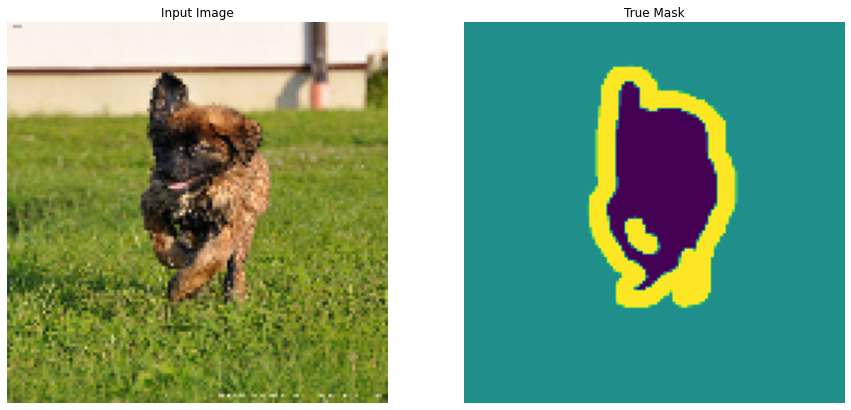

In [12]:
for image, mask in test.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [13]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [16]:
model = tf.keras.models.load_model(path)

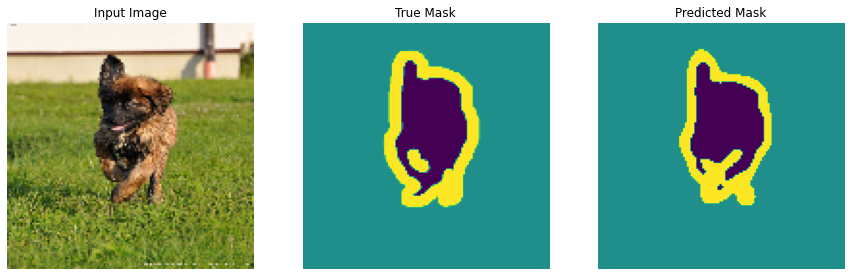

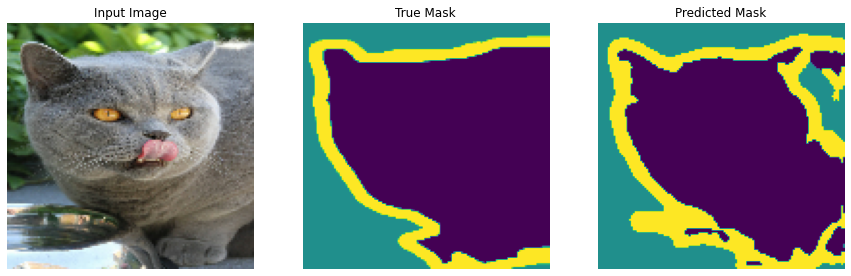

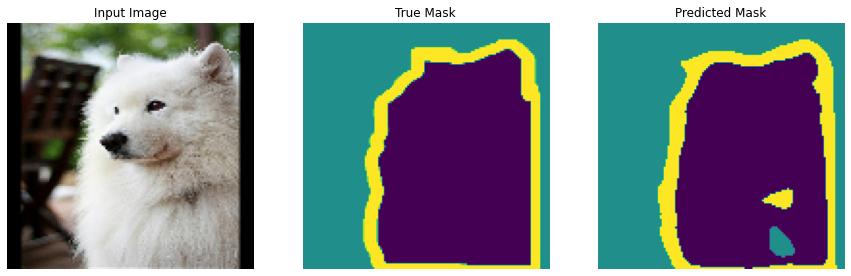

In [17]:
show_predictions(test_dataset, 3)

In [18]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tqdm import tqdm
import time
#converter = trt.TrtGraphConverterV2(input_saved_model_dir=path)
#converter.convert()

# Save the converted model
#converter.save(output_saved_model_dir='./')

In [20]:
# Load converted model and infer
model = tf.saved_model.load(path, tags=[trt.tag_constants.SERVING])
graph_func = model.signatures[trt.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
frozen_func = trt.convert_to_constants.convert_variables_to_constants_v2(graph_func)

In [22]:
time_list = []
for image, _ in tqdm(test_dataset):
  start = time.time()
  pred_mask = frozen_func(image) # 64, 128, 128, 3
  time_list.append(time.time()-start)
  
  

100%|██████████| 58/58 [00:28<00:00,  2.05it/s]


In [23]:
print("Average inference time is: ",np.mean(time_list)/64 * 1000, "ms")

Average inference time is:  7.5014633094442305 ms
